In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import os
os.chdir(r"/content/gdrive/MyDrive/Colab Notebooks/00.study/10.knou")

!pwd
!ls

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/00.study/10.knou
 3_1_Data_Generation_and_Drawing_true.ipynb
'3_2&3_density_estimation_using_Parzen_window_and_Gaussian_Kernel.ipynb'
'4_1_Bayes_Classifier_&_4_2_Drawing_Decision_Boundary.ipynb'
'4강. 베이지안 분류기(Bayes Classifier)'
'Copy of 3_1_Data_Generation_and_Drawing_true.ipynb'
 dataCh4_7.mat
 dataCh4_7.zip
 digitimages_binary.zip
 number_images
 plot_surface.ipynb
 report


In [ ]:
#%cd ./matlab\ data
# %cd ./knou_study
# !mv ./4-1\ Bayes\ Classifier.m.ipynb matlab\ data
!pwd
# %cd matlab\ data
!ls

/content/gdrive/MyDrive/Colab Notebooks/00.study/10.knou
 3_1_Data_Generation_and_Drawing_true.ipynb
'3_2&3_density_estimation_using_Parzen_window_and_Gaussian_Kernel.ipynb'
'4_1_Bayes_Classifier_&_4_2_Drawing_Decision_Boundary.ipynb'
'4강. 베이지안 분류기(Bayes Classifier)'
'Copy of 3_1_Data_Generation_and_Drawing_true.ipynb'
 dataCh4_7.mat
 dataCh4_7.zip
 digitimages_binary.zip
 number_images
 plot_surface.ipynb
 report


매트랩 데이터 불러와서 변수들 저장하기

In [ ]:
from scipy import io # 매트랩 데이터 불러올때 쓰는 모듈
mat_file = io.loadmat('dataCh4_7.mat') #io.loadmat을 사용한다

a = list(mat_file.keys()) #불러오면 딕셔너리 형태여서 키값을 .keys()를 써서 딕셔너리 키값만 받아오는데, 이상한 것도있어서 리스트 타입으로 바꾸면 키값만 추출된다. (넘파이 어레이 쓰면 이상한것도 받아온다)
print(a)

for i in range(3,len(a)): #키값리스트를 보고 몇번째 부터 데이터를 저장할지 확인해본다.
  globals()[a[i]] = mat_file[a[i]] #글로발스를 사용해서 키값을 global 변수로 가져와서 만들고, mat_file[]로 해당 키값을입력해 딕셔너리 value를 호출해서 글로발 변수에 저장 (딕셔너리 타입 인덱싱으로 데이터 추출)
  print(globals()[a[i]].shape) #옥타브 디멘션과 비교해서 데이터가 잘 들어온것으로 확인된다.
  

['__header__', '__version__', '__globals__', 'X1', 'X2', 'X3', 'X1_test', 'X2_test', 'X3_test']
(100, 2)
(100, 2)
(100, 2)
(100000, 2)
(100000, 2)
(100000, 2)


# 4-1 베이지안 분류기

## (1) 데이터로 부터 평균 및 공분산 구하기

클래스별 표본평균 추출해서 표본표평균 집합만들어 보기

In [ ]:
import numpy as np

K=3 #create number of classe in K

x1_mean = np.mean(X1, axis=0) #make means with axis =0 (vertical calculation) / only mean 1*1, with axis =0 1*2 
x2_mean = np.mean(X2, axis=0)
x3_mean = np.mean(X3, axis=0)
M = np.empty((0,x1_mean.shape[0])) # 깡통 만들기, 두번째 인자도 0이면 vstack 작동안함. 예상해서 (3, 2) 넣으면 그대로 쌓임 결과: 6*2

for i in range(1,4):
  M = np.vstack([M, globals()['x{}_mean'.format(i)]])

M

array([[-0.14364878,  0.04379621],
       [ 2.94798437,  2.81600596],
       [ 0.14632016,  3.45188693]])

클래스별 공분산 및 전체 공분산 평균 만들어 보기

In [ ]:
  #표본공분산 3차원 집합
s1 = np.cov(X1[:,0], X1[:,1]) #각클래스 데이터별 공분산을 구한다. 
s2 = np.cov(X2[:,0], X2[:,1])
s3 = np.cov(X3[:,0], X3[:,1])

Ds1=np.expand_dims(s1, axis=0) #공분산 2*2 배열의 차원을 늘려준다 1*2*2가 된다.
Ds2=np.expand_dims(s2, axis=0)
Ds3=np.expand_dims(s3, axis=0)

S = np.vstack([Ds1, Ds2, Ds3]) # 늘린 차원을 결합해준다 (교제 옥타브는 2*2*3으로 표현되나 여기서는 3*2*2이다. 고차원의 인덱싱이 먼저온다.)

  #모든클래스의 평균공분산
smean = (s1+s2+s3)/3

S.shape, smean.shape

((3, 2, 2), (2, 2))

학습데이터 세트와 트레인에러 누적을 위한 0 포멧 생성

In [ ]:
Dtrain = np.vstack([X1,X2,X3])
Etrain = np.zeros((3,1))

Dtrain.shape, Etrain.shape

((300, 2), (3, 1))

## (2) 가우시안 확률분포와 베이지안 분류기

인덱싱으로 해보기

In [ ]:
Etrain = np.zeros((3,1))
N = X1.shape[0]

for l in range(1,4):
  globals()['d{}'.format(l)] = np.empty((3,1))

for k in range(K):
  X = Dtrain[k*100:(k+1)*100,:]
  for i in range(N):
    for j in range(K): #j로 각 클래스별 평균과 위에 초기에 할당한 k 클래스에 해당하는 각각의 좌표 100개의 거리 각각를 구한다.
      d1[j] = (X[i,:] - M[j,:]) @ (X[i,:]-M[j,:]).T #단위 공분산 행렬을 가정한 판별함수
      d2[j] = np.dot((X[i,:] - M[j,:]), np.linalg.inv(smean)) @ (X[i,:] - M[j,:]).T #모든클라스에 동인한 공분산을 가정한 판별함수 / np.dot는 행렬 연속적으로 곱해주지 못한다. (np.dot(a,b,c) -> 안됨)
      d3[j] = (X[i,:] - M[j,:]) @ np.linalg.inv(np.reshape(S[j,:,:], (2,2))) @ (X[i,:] - M[j,:]).T #각 클라스에 제각각의 공분산을 가정한 판별함수
    min1v, min1i = min(d1), np.argmin(d1) #가장 거리?가 짧은 것의 인덱스를 받아온다.
    if min1i != k: Etrain[0,0] = Etrain[0,0] + 1 #가장짧은 인덱스와 초기에 선언한 클라스 k값을 비교한다. (애초에 k 클라스라는 가정을하고 거리를 구했는데 가장거리가 짧은 인덱스 값과 k 다르면 딴것하고 가깝다는 이야기 이기때문에 에러)
    min2v, min2i = min(d2), np.argmin(d2)
    if min2i != k: Etrain[1,0] = Etrain[1,0] + 1
    min3v, min3i = min(d3), np.argmin(d3)
    if min3i != k: Etrain[2,0] = Etrain[2,0] + 1

error_rate = Etrain/(N*k) #각 판별함수마다 3개의 클라스에서 각클래스별 100개씩 진행했으므로 전체 이트레인의 연산 실행수는 3*100번이다. 중간에 j는 for 밑에 없고 min으로 1가지 값만 추출되었으니 무관하다.

Etrain, error_rate


(array([[36.],
        [39.],
        [29.]]), array([[0.18 ],
        [0.195],
        [0.145]]))

##### 연습 vstack 사용해보기 (쌓을 인덱스의 위치와 숫자만 알면 데이터 누적되는 것은 쌓이는 방향의 포멧은 비어도 된다.)

In [ ]:
Etrain = np.zeros((3,1)) #트레인에러가 누적되서 런타임할때 지워주기 위해 추가함 
N = X1.shape[0]

for k in range(K):
  X = Dtrain[k*100:(k+1)*100,:]
  for i in range(N):
    for l in range(1,4):
      globals()['d{}'.format(l)] = np.empty((0,1))
    for j in range(K): #vstack --------------------------
      f_d1 = (X[i,:] - M[j,:]) @ (X[i,:]-M[j,:]).T
      d1 = np.vstack([d1, f_d1])
      f_d2 = (X[i,:] - M[j,:]) @ np.linalg.inv(smean) @ (X[i,:] - M[j,:]).T 
      d2 = np.vstack([d2, f_d2])
      f_d3 = (X[i,:] - M[j,:]) @ np.linalg.inv(np.reshape(S[j,:,:], (2,2))) @ (X[i,:] - M[j,:]).T
      d3 = np.vstack([d3, f_d3]) # ----------------------
    min1v, min1i = min(d1), np.argmin(d1)
    if min1i != k: Etrain[0,0] = Etrain[0,0] + 1
    min2v, min2i = min(d2), np.argmin(d2)
    if min2i != k: Etrain[1,0] = Etrain[1,0] + 1
    min3v, min3i = min(d3), np.argmin(d3)
    if min3i != k: Etrain[2,0] = Etrain[2,0] + 1

error_rate = Etrain/(N*k)

Etrain, error_rate

(array([[36.],
        [39.],
        [29.]]), array([[0.18 ],
        [0.195],
        [0.145]]))

# 4-2. 베이지안 분류기 결정 경계

위에 4-1 베이지안 분류기에서 M, K, S, smean 동일하게 사용, 직계좌표 XY만 생성해준다.

In [ ]:
x = np.arange(-5.5, 5.1, 0.1)
y = np.arange(-5.5, 5.1, 0.1)
x, y = np.meshgrid(x,y)
x1 = np.reshape(x, (-1,1), order='F') #order F reshape row to column
y1 = np.reshape(y, (-1,1), order='F')
XY = np.hstack([x1,y1])

XY.shape, XY

((11236, 2), array([[-5.5, -5.5],
        [-5.5, -5.4],
        [-5.5, -5.3],
        ...,
        [ 5. ,  4.8],
        [ 5. ,  4.9],
        [ 5. ,  5. ]]))

## (1) 결정 경계

In [ ]:
res_classify = np.empty((3,XY.shape[0])) #res_classify 포멧을 만들어준다. 아래 for구분 i를 보면서 컬럼의 개수를 추측해본다. 연산이 복잡해서져 컬럼개수 측정이 불가능할경우 어팬드를 사용한다음 브이스택으로 쌓아주는 방법을 생각해볼 수 있을것 같다. 

for l in range(1,4):
  globals()['d{}'.format(l)] = np.empty((3,1))

for i in range(XY.shape[0]): #직계좌표의 총크기로 설정 (좌표마다 z 값을 찾으려 할 것 같음)
  for j in range(K): #클레스별로 평균을 빼주기위함
    d1[j] = np.dot(XY[i,:] - M[j,:], (XY[i,:]- M[j,:]).T)
    d2[j] = (XY[i,:] -M[j,:]) @ np.linalg.inv(smean) @ ((XY[i,:] - M[j,:]).T)
    d3[j] = (XY[i,:] - M[j,:]) @ np.linalg.inv(np.reshape(S[j,:,:], (2,2))) @ (XY[i,:] - M[j,:]).T
  min1v, min1i = min(d1), np.argmin(d1)
  res_classify[0,i] = min1i
  min2v, min2i = min(d2), np.argmin(d2)
  res_classify[1,i] = min2i
  min3v, min3i = min(d3), np.argmin(d3)
  res_classify[2,i] = min3i
  #위 클래스 결정 함수에 따라서 각 직계좌표?에서 구한 최소거리의 인덱스를 추출하여 res_classify에 저장한다. 즉 직계좌표별로 이구간의 판별함수로 부터 추출된 클라스를 정하는 것임. resclassify를 보면 값이 1, 2, 3으로 한정된다. 아래에서 이것을 근거로 등고선함수를 이용해서 좌표별 영역을 표시한다.

res_classify.shape

(3, 11236)

각각의 공분산 형태에 따라 판별함수별 결정경계 그려보기

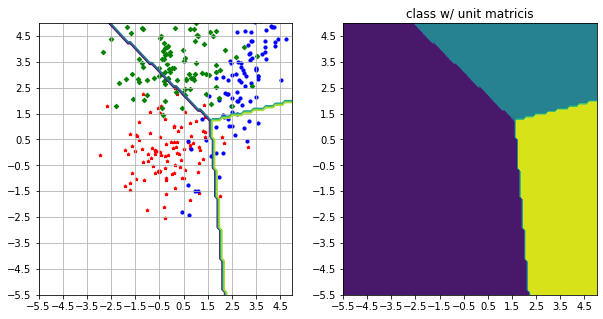

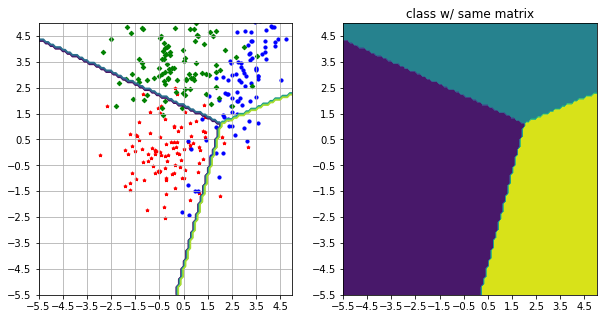

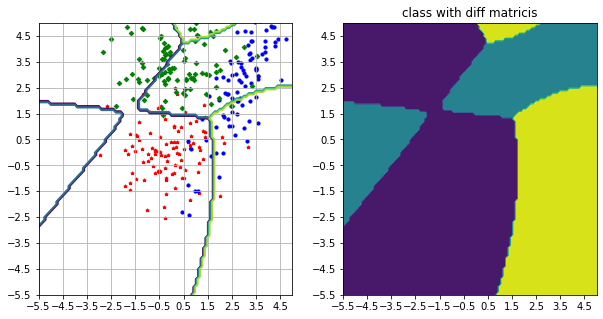

In [ ]:
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D 복습용
# fig = plt.figure()
# ax = Axes3D(fig)
# ax.plot_surface(x,y,z, rstride = 1, cstride = 1, cmap ='spring')
title = ['class w/ unit matricis', 'class w/ same matrix', 'class with diff matricis'] #matrix의 복수형은 matricis...

for m in range(3):
  flg = plt.figure(figsize=(10,5)) #차트 각각 크기
  chart1 = flg.add_subplot(1,2,1)
  chart2 = flg.add_subplot(1,2,2, sharex = chart1, sharey = chart1) #차트1의 x축 y축설정을 가져온다.

  plt.axis([-5.5, 5, -5.5, 5]) #축의 범위
  plt.xticks(np.arange(-5.5, 5, 1)) #눈금 간격설정
  plt.yticks(np.arange(-5.5, 5, 1)) 
  chart1.grid() #격자를 설정한다.
  chart1.scatter(X1[:,0], X1[:,1], c='red', marker = '*', s = 10 ) #클래스별 산점도 입력, chart를 지정해서 한다. subplot의 경우 지정하지 않으면 이상해진다. 
  chart1.scatter(X2[:,0], X2[:,1], c = 'blue', marker = 'o', s = 10)
  chart1.scatter(X3[:,0], X3[:,1], c = 'green', marker = 'D', s = 10)
  res = np.reshape(res_classify[m,:], (x.shape)) #x,y와 같은 형식으로 라벨값 리쉐이핑, 라벨 = 좌표별 높이
  plt.title(title[m])
  chart1.contour(x,y,res)
  chart2.contourf(x,y,res) 
  plt.show() #show가 없으면 contour3개가 겹쳐서 나온다.

  #결정경계 함수는 직접적으로 Xn의 데이터로 계산되지 않는다. 직계좌표와 클래스별 평균(d1), +클래스별표본공분산의 전체평균(d2), +클래스별표본공분산(d3) 만 있으면 구할수 있다.....

  #산점도를 chart1이아니고 plt로만 하면 첫번째 그림에는 산점도 및 격자표시등 설정이 표시 되지 않고 두번째 그림만 타이틀과 산점도만 표시된다. 아마 마지막에 subplot에서 위치(라벨인덱싱)한것이 plot기본(글로벌?) 설정을 모두 가져가는 듯한다.